#1.Imports

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import choice,randint
from collections import Counter
from sklearn.base import BaseEstimator,ClassifierMixin,clone
from sklearn.utils import resample
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,ShuffleSplit,validation_curve
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import balanced_accuracy_score,make_scorer,classification_report
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest,mutual_info_classif

#2.Two simple Bagging implementation

In [2]:
class SimpleBagger(BaseEstimator,ClassifierMixin):
  def __init__(self,base_estimator=SVC(),n_estimators=5):
    self.base_estimator=base_estimator
    self.n_estimators=n_estimators
  def get_params(self,deep=True):
    return {'base_estimator':self.base_estimator,'n_estimators':self.n_estimators}
  def set_params(self,**params):
    self.base_estimator=params['base_estimator']
    self.n_estimators=params['n_estimators']
    return self
  def fit(self,X,y):
    self.members=[clone(self.base_estimator) for _ in range(self.n_estimators)]
    for member in self.members:
      member.fit(*resample(X,y))
    return self
  def predict(self,X):
    preds=np.array([member.predict(X) for member in self.members])
    return np.array([Counter(votes).most_common(1)[0][0] for votes in preds.T])
  def score(self,X,y):
    return sum(self.predict(X)==y)/X.shape[0]


In [11]:
data = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(data.data,data.target,test_size=0.33, random_state=42)

In [61]:
bagger=SimpleBagger(SVC(),10)
bagger.fit(X_train,y_train)
bagger.score(X_test,y_test)

0.9414893617021277

In [66]:
baggerGrid=GridSearchCV(SimpleBagger(),{'n_estimators':[2,5,10,20,50],'base_estimator':(SVC(),KNeighborsClassifier(),DecisionTreeClassifier())})
baggerGrid.fit(data.data,data.target)
print(f"Best Ensemble:{baggerGrid.best_params_}\nIts score:{baggerGrid.best_score_}")


Best Ensemble:{'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'), 'n_estimators': 50}
Its score:0.9561092997981679


In [3]:
class LessSimpleBagger(ClassifierMixin):
  def __init__(self,base_estimator=SVC(),n_estimators=5,max_features=0.5):
    self.base_estimator=base_estimator
    self.n_estimators=n_estimators
    self.max_features=max_features
  def get_params(self,deep=True):
    return {'base_estimator':self.base_estimator,'n_estimators':self.n_estimators,'max_features':self.max_features}
  def set_params(self,**params):
    self.base_estimator=params['base_estimator']
    self.n_estimators=params['n_estimators']
    self.max_features=params['max_features']
    return self
  def fit(self,X,y):
    self.members=[(clone(self.base_estimator),choice(X.shape[1],size=(randint(self.max_features*X.shape[1])+1,))) for _ in range(self.n_estimators)]
    for member,features in self.members:
      member.fit(*resample(X[:,features],y))
  def predict(self,X):
    preds=np.array([member.predict(X[:,features]) for member,features in self.members])
    return np.array([Counter(votes).most_common(1)[0][0] for votes in preds.T])
  def score(self,X,y):
    return sum(self.predict(X)==y)/X.shape[0]

In [65]:
baggerGrid=GridSearchCV(LessSimpleBagger(),{'n_estimators':[2,5,10,20,50],'base_estimator':(SVC(),KNeighborsClassifier(),DecisionTreeClassifier()),'max_features':[0.5,0.8,1.]})
baggerGrid.fit(data.data,data.target)
print(f"Best Ensemble:{baggerGrid.best_params_}\nIts score:{baggerGrid.best_score_}")

Best Ensemble:{'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'), 'max_features': 1.0, 'n_estimators': 20}
Its score:0.9648657040832168


#3.OCD high-dimensional dataset

In [2]:
!pip install GEOparse

     |████████████████████████████████| 286kB 4.4MB/s 
  Created wheel for GEOparse: filename=GEOparse-2.0.3-cp37-none-any.whl size=29034 sha256=baa473adc8e0526bc12ea6e5c5c5d8fe7548335c53a3372e9c6309fbc9d64a71
  Stored in directory: /root/.cache/pip/wheels/c6/5e/b4/7109a7b8e8046bd8586349a6ac1a76ef8190d12a61a7b4cf0d
Successfully built GEOparse


In [3]:
import GEOparse as G
gse = G.get_GEO(geo="GSE60190", destdir="./")
#https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE60190

16-Apr-2021 20:33:27 DEBUG utils - Directory ./ already exists. Skipping.
16-Apr-2021 20:33:27 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE60nnn/GSE60190/soft/GSE60190_family.soft.gz to ./GSE60190_family.soft.gz
100%|██████████| 65.6M/65.6M [00:00<00:00, 111MB/s]
16-Apr-2021 20:33:28 DEBUG downloader - Size validation passed
16-Apr-2021 20:33:28 DEBUG downloader - Moving /tmp/tmphdlrt7y6 to /content/GSE60190_family.soft.gz
16-Apr-2021 20:33:28 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE60nnn/GSE60190/soft/GSE60190_family.soft.gz
16-Apr-2021 20:33:28 INFO GEOparse - Parsing ./GSE60190_family.soft.gz: 
16-Apr-2021 20:33:28 DEBUG GEOparse - DATABASE: GeoMiame
16-Apr-2021 20:33:28 DEBUG GEOparse - SERIES: GSE60190
16-Apr-2021 20:33:28 DEBUG GEOparse - PLATFORM: GPL6947
16-Apr-2021 20:33:30 DEBUG GEOparse - SAMPLE: GSM1467273
16-Apr-2021 20:33:30 DEBUG GEOparse - SAMPLE: GSM1467274
16-Apr-2021 20:33:30 DEBUG GEOparse - SAMPLE

In [4]:
y=[]
X={}
for sample in gse.gsms:
  X_sample=gse.gsms[sample].table.set_index('ID_REF')['VALUE']
  X_sample.index.rename('GENE',inplace=True)
  X[sample]=X_sample
  if gse.gsms[sample].metadata['title'][0].startswith('DLPFC_Control'):
    y+=[0]
  else:
    y+=[1]
X=pd.DataFrame(X)
y=np.array(y)
X.head()

,GSM1467273,GSM1467274,GSM1467275,GSM1467276,GSM1467277,GSM1467278,GSM1467279,GSM1467280,GSM1467281,GSM1467282,GSM1467283,GSM1467284,GSM1467285,GSM1467286,GSM1467287,GSM1467288,GSM1467289,GSM1467290,GSM1467291,GSM1467292,GSM1467293,GSM1467294,GSM1467295,GSM1467296,GSM1467297,GSM1467298,GSM1467299,GSM1467300,GSM1467301,GSM1467302,GSM1467303,GSM1467304,GSM1467305,GSM1467306,GSM1467307,GSM1467308,GSM1467309,GSM1467310,GSM1467311,GSM1467312,...,GSM1467366,GSM1467367,GSM1467368,GSM1467369,GSM1467370,GSM1467371,GSM1467372,GSM1467373,GSM1467374,GSM1467375,GSM1467376,GSM1467377,GSM1467378,GSM1467379,GSM1467380,GSM1467381,GSM1467382,GSM1467383,GSM1467384,GSM1467385,GSM1467386,GSM1467387,GSM1467388,GSM1467389,GSM1467390,GSM1467391,GSM1467392,GSM1467393,GSM1467394,GSM1467395,GSM1467396,GSM1467397,GSM1467398,GSM1467399,GSM1467400,GSM1467401,GSM1467402,GSM1467403,GSM1467404,GSM1467405
GENE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ILMN_1762337,7.386233,7.383662,7.391908,7.394525,7.380174,7.392893,7.395035,7.385740,7.392392,7.381276,7.400817,7.400051,7.451436,7.392118,7.395321,7.385121,7.385313,7.375387,7.390471,7.419163,7.380511,7.403535,7.398820,7.393632,7.394032,7.385716,7.387610,7.392589,7.387535,7.393915,7.379798,7.394142,7.419568,7.385260,7.382448,7.390901,7.386295,7.399189,7.397037,7.390348,...,7.388379,7.389425,7.385863,7.382194,7.410882,7.405704,7.404767,7.395976,7.378603,7.398384,7.384679,7.404515,7.389422,7.385648,7.389029,7.385783,7.395879,7.398518,7.384185,7.402536,7.380916,7.386598,7.429825,7.395899,7.384458,7.383185,7.404278,7.384904,7.390146,7.384375,7.388642,7.391313,7.383116,7.378260,7.386379,7.394498,7.382933,7.386308,7.383719,7.397961
ILMN_2055271,7.566603,7.503766,7.514338,7.454698,7.461963,7.469844,7.529504,7.440339,7.432822,7.459135,7.543113,7.452501,7.705146,7.596125,7.498154,7.545299,7.406923,7.401228,7.421056,7.462629,7.400502,7.397459,7.424542,7.500946,7.544474,7.500917,7.466203,7.422578,7.429444,7.405371,7.445335,7.679057,7.536705,7.440260,7.393190,7.617611,7.590569,7.435465,7.400972,7.390185,...,7.456618,7.420314,7.467558,7.464614,7.425586,7.488138,7.437731,7.435836,7.514324,7.528472,7.449622,7.520484,7.460191,7.443415,7.463826,7.424417,7.430239,7.525707,7.486611,7.451858,7.491203,7.541226,7.456086,7.427137,7.536929,7.504397,7.417781,7.450517,7.488699,7.401609,7.578161,7.503312,7.467789,7.500765,7.470310,7.502963,7.446026,7.490703,7.434865,7.446862
ILMN_1736007,7.395490,7.415111,7.411259,7.452471,7.406781,7.400772,7.464517,7.428403,7.393926,7.419256,7.430893,7.463886,7.441676,7.399954,7.416419,7.394407,7.394149,7.471065,7.413662,7.414325,7.396228,7.408074,7.457374,7.426909,7.408528,7.446387,7.398156,7.400009,7.429735,7.457548,7.397040,7.392384,7.418896,7.426542,7.427151,7.426393,7.530829,7.408560,7.458966,7.410572,...,7.392883,7.427061,7.426749,7.421202,7.409734,7.415489,7.396247,7.386492,7.395270,7.392601,7.405761,7.444102,7.398172,7.406047,7.405839,7.411998,7.409239,7.414095,7.398139,7.407446,7.422754,7.393836,7.399502,7.428688,7.413477,7.421273,7.439048,7.400521,7.406692,7.400641,7.417159,7.412115,7.388127,7.387117,7.407231,7.407277,7.393548,7.394282,7.420361,7.401746
ILMN_2383229,7.396522,7.380184,7.396145,7.437754,7.389166,7.386301,7.381726,7.411211,7.393087,7.388776,7.410690,7.394225,7.380928,7.394825,7.389272,7.381265,7.384548,7.389634,7.385577,7.390940,7.391638,7.398699,7.386617,7.392951,7.390627,7.385841,7.383043,7.387548,7.379674,7.414392,7.387134,7.391204,7.396711,7.383633,7.388312,7.422167,7.391642,7.394340,7.405836,7.386327,...,7.390146,7.389623,7.390705,7.398594,7.398851,7.414568,7.396422,7.394282,7.392053,7.387050,7.383961,7.381736,7.406727,7.385173,7.377312,7.400326,7.415997,7.379473,7.389521,7.391817,7.401613,7.400046,7.396275,7.400992,7.394005,7.410140,7.401575,7.390314,7.388930,7.403501,7.395504,7.383655,7.387001,7.387021,7.385719,7.393925,7.389303,7.390593,7.415308,7.388519
ILMN_1806310,7.406622,7.390529,7.390354,7.399255,7.428401,7.395842,7.405722,7.389

##3.1.LessSimpleBagger

In [7]:
bagger=LessSimpleBagger(DecisionTreeClassifier(max_depth=10),n_estimators=5,max_features=0.5)
scores = cross_val_score(bagger, X.T.to_numpy(), y, cv=8,scoring=make_scorer(balanced_accuracy_score))
print(f"Balanced Accuracies:{scores}\nAverage Balanced Accuracies:{scores.mean()}")


Balanced Accuracies:[0.5        0.46153846 0.50961538 0.75       0.625      0.625
 0.625      0.62820513]
Average Balanced Accuracies:0.5905448717948718


##3.2.AdaBoost

In [8]:
clf = AdaBoostClassifier(n_estimators=100)
scores = cross_val_score(clf, X.T, y, cv=8,verbose=2,scoring=make_scorer(balanced_accuracy_score))
print(f"AdaBoost average balanced accuracy:{scores.mean()}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total= 1.2min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV] ................................................. , total= 1.1min
[CV]  ................................................................
[CV] ................................................. , total= 1.1min
[CV]  ................................................................
[CV] ................................................. , total= 1.1min
[CV]  ................................................................
[CV] ................................................. , total= 1.1min
[CV]  ................................................................
[CV] ................................................. , total= 1.1min
[CV]  ................................................................
[CV] ................................................. , total= 1.1min
[CV]  ................................................................
[CV] ................................................. , total= 1.1min
AdaBoost average balanced accuracy:0.5893429487179487


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  9.0min finished


##3.3.Random Forest

Each tree is built on at most square root of data features.

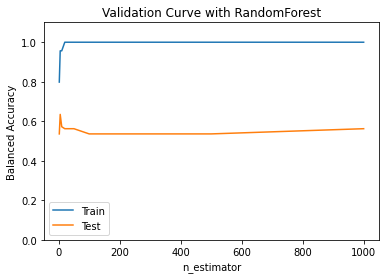

In [9]:
n_estimators_param=[2,5,10,20,50,100,200,500,1000]
train_scores,test_scores=validation_curve(RandomForestClassifier(max_features='sqrt'),X.T,y,'n_estimators',n_estimators_param,cv=ShuffleSplit(n_splits=1,test_size=0.2),scoring=make_scorer(balanced_accuracy_score))
plt.plot(n_estimators_param,train_scores)
plt.plot(n_estimators_param,test_scores)
plt.title("Validation Curve with RandomForest")
plt.xlabel("n_estimator")
plt.ylabel("Balanced Accuracy")
plt.ylim(0.0, 1.1)
plt.legend(['Train','Test'],loc="best")
plt.show()

Each tree is built on at most log2 of data features.

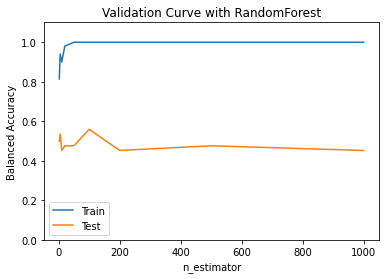

In [11]:
n_estimators_param=[2,5,10,20,50,100,200,500,1000]
train_scores,test_scores=validation_curve(RandomForestClassifier(max_features='log2'),X.T,y,'n_estimators',n_estimators_param,cv=ShuffleSplit(n_splits=1,test_size=0.2),scoring=make_scorer(balanced_accuracy_score))
plt.plot(n_estimators_param,train_scores)
plt.plot(n_estimators_param,test_scores)
plt.title("Validation Curve with RandomForest")
plt.xlabel("n_estimator")
plt.ylabel("Balanced Accuracy")
plt.ylim(0.0, 1.1)
plt.legend(['Train','Test'],loc="best")
plt.show()

##3.4.LDA

In [12]:
scores = cross_val_score(LDA(), X.T, y, cv=8,verbose=2,scoring=make_scorer(balanced_accuracy_score))
print(f"LDA average balanced accuracy:{scores.mean()}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=   2.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV] ................................................. , total=   2.5s
[CV]  ................................................................
[CV] ................................................. , total=   2.5s
[CV]  ................................................................
[CV] ................................................. , total=   2.4s
[CV]  ................................................................
[CV] ................................................. , total=   2.4s
[CV]  ................................................................
[CV] ................................................. , total=   2.4s
[CV]  ................................................................
[CV] ................................................. , total=   2.5s
[CV]  ................................................................
[CV] ................................................. , total=   2.5s
LDA average balanced accuracy:0.5729166666666666


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   19.8s finished


##3.5.With PCA & a simple classifier

Explained variance:[0.2150034  0.14759176]


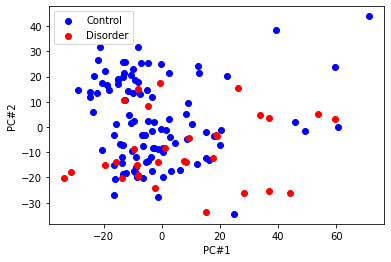

In [31]:
pca=PCA(n_components=2)
Xprime=pca.fit_transform(X.T)
print(f"Explained variance:{pca.explained_variance_ratio_}")
plt.scatter(Xprime[y==0,0],Xprime[y==0,1],c='blue',label='Control')
plt.scatter(Xprime[y==1,0],Xprime[y==1,1],c='red',label='Disorder')
plt.xlabel('PC#1')
plt.ylabel('PC#2')
plt.legend(loc='best')
plt.show()

In [28]:
pca=PCA()
pca.fit_transform(X.T)
var=0.
n_pc=0
for pc_var in pca.explained_variance_ratio_:
  var+=pc_var
  n_pc+=1
  if var>=0.9:
    break
print(n_pc)

49


In [34]:
pipe=Pipeline([('pca',PCA(n_components=49)),('tree',DecisionTreeClassifier())])
scores = cross_val_score(pipe, X.T, y, cv=8,verbose=2,scoring=make_scorer(balanced_accuracy_score))
print(f"PCA+Tree average balanced accuracy:{scores.mean()}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] ................................................. , total=   1.6s
[CV]  ................................................................
[CV] ................................................. , total=   1.7s
[CV]  ................................................................
[CV] ................................................. , total=   1.6s
[CV]  ................................................................
[CV] ................................................. , total=   1.6s
[CV]  ................................................................
[CV] ................................................. , total=   1.5s
[CV]  ................................................................
[CV] ................................................. , total=   1.6s
[CV]  ................................................................
[CV] ................................................. , total=   1.6s
PCA+Tree average balanced accuracy:0.530849358974359


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   12.8s finished


##3.6.With PCA & an Ensemble

In [37]:
pipe=Pipeline([('pca',PCA(n_components=2)),('ab',AdaBoostClassifier(n_estimators=100))])
scores = cross_val_score(pipe, X.T, y, cv=8,verbose=2,scoring=make_scorer(balanced_accuracy_score))
print(f"PCA+AB average balanced accuracy:{scores.mean()}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=   1.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] ................................................. , total=   1.1s
[CV]  ................................................................
[CV] ................................................. , total=   1.1s
[CV]  ................................................................
[CV] ................................................. , total=   1.1s
[CV]  ................................................................
[CV] ................................................. , total=   1.1s
[CV]  ................................................................
[CV] ................................................. , total=   1.1s
[CV]  ................................................................
[CV] ................................................. , total=   1.1s
[CV]  ................................................................
[CV] ................................................. , total=   1.1s
PCA+AB average balanced accuracy:0.5673076923076923


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    8.9s finished


In [35]:
pipe=Pipeline([('pca',PCA(n_components=49)),('tree',RandomForestClassifier())])
scores = cross_val_score(pipe, X.T, y, cv=8,verbose=2,scoring=make_scorer(balanced_accuracy_score))
print(f"PCA+RF average balanced accuracy:{scores.mean()}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=   1.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] ................................................. , total=   1.8s
[CV]  ................................................................
[CV] ................................................. , total=   1.8s
[CV]  ................................................................
[CV] ................................................. , total=   1.8s
[CV]  ................................................................
[CV] ................................................. , total=   1.7s
[CV]  ................................................................
[CV] ................................................. , total=   1.7s
[CV]  ................................................................
[CV] ................................................. , total=   1.7s
[CV]  ................................................................
[CV] ................................................. , total=   1.8s
PCA+RF average balanced accuracy:0.5416666666666666


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   13.9s finished


##3.7.With Univariate Feature Selection & a simple classifier

In [6]:
kbest=SelectKBest(score_func=mutual_info_classif,k=2)
kbest.fit(X.T,y)

SelectKBest(k=2, score_func=<function mutual_info_classif at 0x7efc7626a200>)

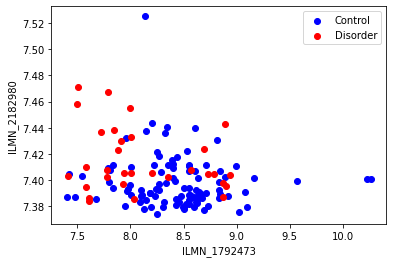

In [17]:
Xprime=kbest.transform(X.T)
plt.scatter(Xprime[y==0,0],Xprime[y==0,1],c='blue',label='Control')
plt.scatter(Xprime[y==1,0],Xprime[y==1,1],c='red',label='Disorder')
plt.xlabel(X.index[kbest.get_support()][0])
plt.ylabel(X.index[kbest.get_support()][1])
plt.legend(loc='best')
plt.show()



In [19]:
pipe=Pipeline([('kbest',SelectKBest(score_func=mutual_info_classif,k=5)),('svm',SVC())])
scores = cross_val_score(pipe, X.T, y, cv=ShuffleSplit(n_splits=1,test_size=0.2),verbose=2,scoring=make_scorer(balanced_accuracy_score))
print(f"5best+SVM average balanced accuracy:{scores.mean()}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total= 2.4min
5best+SVM average balanced accuracy:0.5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min finished


##3.8.With Univariate Feature Selection & an Ensemble

In [5]:
pipe=Pipeline([('kbest',SelectKBest(score_func=mutual_info_classif,k=3)),('ab',AdaBoostClassifier(n_estimators=100))])
scores = cross_val_score(pipe, X.T, y, cv=ShuffleSplit(n_splits=1,test_size=0.2),verbose=2,scoring=make_scorer(balanced_accuracy_score))
print(f"3best+ average balanced accuracy:{scores.mean()}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total= 2.3min
3best+ average balanced accuracy:0.6863636363636363


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min finished


Classification report for the best classifier:

In [9]:
X_train, X_test, y_train, y_test=train_test_split(X.T,y,test_size=0.33)
pipe.fit(X_train,y_train)
print(classification_report(y_test,pipe.predict(X_test),target_names=['Control','Disorder']))

              precision    recall  f1-score   support

     Control       0.71      0.84      0.77        32
    Disorder       0.17      0.08      0.11        12

    accuracy                           0.64        44
   macro avg       0.44      0.46      0.44        44
weighted avg       0.56      0.64      0.59        44



In [21]:
pipe=Pipeline([('kbest',SelectKBest(score_func=mutual_info_classif,k=20)),('tree',RandomForestClassifier())])
scores = cross_val_score(pipe, X.T, y, cv=ShuffleSplit(n_splits=1,test_size=0.2),verbose=2,scoring=make_scorer(balanced_accuracy_score))
print(f"20Best+RF average balanced accuracy:{scores.mean()}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total= 2.3min
20Best+RF average balanced accuracy:0.5597826086956521


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min finished
